# **IgFold**: Fast, accurate antibody structure prediction

Official notebook for [IgFold](https://www.biorxiv.org/content/10.1101/2022.04.20.488972): Fast, accurate antibody structure prediction from deep learning on massive set of natural antibodies.  The code, data, and weights for this work are made available for non-commercial use. For commercial inquiries, please contact `jruffolo[at]jhu.edu`.

In [1]:
#@title Input antibody Fv sequences then press `Runtime` -> `Run all`

import os
import sys

python_version = f"{sys.version_info.major}.{sys.version_info.minor}"

name = "my_antibody" #@param {type:"string"}
pred_dir = name
os.makedirs(pred_dir, exist_ok=True)

#@markdown Enter antibody sequences for structure prediction. To predict a nanobody structure (or an individual heavy or light chain), simply provide one sequence.
heavy_sequence = "EVQLVQSGPEVKKPGTSVKVSCKASGFTFMSSAVQWVRQARGQRLEWIGWIVIGSGNTNYAQKFQERVTITRDMSTSTAYMELSSLRSEDTAVYYCAAPYCSSISCNDGFDIWGQGTMVTVS" #@param {type:"string"}
light_sequence = "DVVMTQTPFSLPVSLGDQASISCRSSQSLVHSNGNTYLHWYLQKPGQSPKLLIYKVSNRFSGVPDRFSGSGSGTDFTLKISRVEAEDLGVYFCSQSTHVPYTFGGGTKLEIK" #@param {type:"string"}

sequences = {}
if len(heavy_sequence) > 0:
    sequences["H"] = heavy_sequence
if len(light_sequence) > 0:
    sequences["L"] = light_sequence

#@markdown Perform structural refinement with OpenMM
do_refine = True #@param {type:"boolean"}
#@markdown Renumber predicted antibody structure (Chothia) with AbNumber
do_renum = False #@param {type:"boolean"}
#@markdown Use only a single model for predictions (instead of model ensemble)
single_model = False #@param {type:"boolean"}

In [2]:
#@title Install dependencies

import os
import sys

# 1. 动态获取 Python 版本
PYTHON_VERSION = f"{sys.version_info.major}.{sys.version_info.minor}"

# ----------------- 安装 Conda (Mamba) -----------------
if not os.path.isfile("CONDA_READY"):
    print("正在安装 Conda (此过程可能需要几分钟)...")
    os.system("wget -qnc https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh")
    os.system("bash Mambaforge-colab-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

# ----------------- 安装 IgFold (修正版) -----------------
if not os.path.isfile("CODE_READY"):
    print("正在安装依赖 (IgFold, PyTorch)...")

    # 修正：不要强制指定 torch==1.11.0，让 pip 自动选择适合 Python 3.12 的版本
    # IgFold 会自动拉取兼容的 PyTorch
    os.system("pip install -q 'igfold>=0.3.0'")

    # 安装辅助工具
    os.system("pip install -q --no-warn-conflicts 'py3Dmol>=2.0.1' matplotlib seaborn")

    # 确保 Amber 安装（如果需要）
    os.system(f"mamba install -y -q -c conda-forge openmm pdbfixer python='{PYTHON_VERSION}'")

    os.system("touch CODE_READY")

# ----------------- 路径修复 -----------------
# 确保系统能找到刚才安装的包
site_pkg_path = f"/usr/local/lib/python{PYTHON_VERSION}/site-packages"
if site_pkg_path not in sys.path:
    sys.path.insert(0, site_pkg_path)
    print(f"已修复路径: {site_pkg_path}")

# ----------------- 验证与排错 -----------------
try:
    import igfold
    # 检查究竟导入了哪个文件
    print(f"Import 来源: {igfold.__file__}")

    # 尝试获取版本
    if hasattr(igfold, '__version__'):
        print(f"成功导入 IgFold! 版本: {igfold.__version__}")
    else:
        print("警告: IgFold 模块已加载，但没有版本信息。可能是命名空间包或安装不完整。")

except ImportError as e:
    print(f"导入失败: {e}")
except AttributeError as e:
    print(f"属性错误: {e}")
    print("如果在上方看到了 'Import 来源' 指向 '/content/igfold'，请删除该文件夹。")

已修复路径: /usr/local/lib/python3.12/site-packages


Import 来源: /usr/local/lib/python3.12/dist-packages/igfold/__init__.py
警告: IgFold 模块已加载，但没有版本信息。可能是命名空间包或安装不完整。


/usr/local/lib/python3.12/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
import torch
import sys

# ----------------- 安全版 PyTorch 2.6+ 补丁 -----------------
# 逻辑：只有当还没有备份过原始函数时，才进行备份。
# 这样保证 torch.original_load_func 永远是最初那个纯净的 torch.load
if not hasattr(torch, "original_load_func"):
    torch.original_load_func = torch.load

def safe_patched_load(*args, **kwargs):
    """
    安全补丁：自动处理 weights_only 参数
    """
    # 强制将 weights_only 设为 False (如果调用者没指定)
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False

    # 调用备份的原始函数
    return torch.original_load_func(*args, **kwargs)

# 应用补丁
torch.load = safe_patched_load
print("PyTorch 2.6+ 补丁已安全应用。")
# -----------------------------------------------------------

PyTorch 2.6+ 补丁已安全应用。


In [6]:
#@title Predict antibody structure with IgFold

if f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

from igfold.utils.visualize import *
from igfold import IgFoldRunner

num_models = 1 if single_model else 4
igfold = IgFoldRunner(num_models=num_models)
# 1. 设置精修开关为 False
do_refine = False   # <--- 关键修改：关闭它！
pred_pdb = os.path.join(pred_dir, f"{name}.pdb")
pred = igfold.fold(
    pred_pdb,
    sequences=sequences,
    do_refine=do_refine,
    use_openmm=True,
    do_renum=do_renum,
)
show_pdb(pred_pdb, len(sequences), bb_sticks=False, sc_sticks=True, color="rainbow")


    The code, data, and weights for this work are made available for non-commercial use 
    (including at commercial entities) under the terms of the JHU Academic Software License 
    Agreement. For commercial inquiries, please contact awichma2[at]jhu.edu.
    License: https://github.com/Graylab/IgFold/blob/main/LICENSE.md
    
Loading 4 IgFold models...
Using device: cpu
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_1.ckpt...
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_2.ckpt...
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_3.ckpt...
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_5.ckpt...
Successfully loaded 4 IgFold models.
Loaded AntiBERTy model.


/usr/local/lib/python3.12/dist-packages/igfold/model/components/IPABlock.py:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with disable_tf32(), autocast(enabled = False):


Completed folding in 45.52 seconds.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
# 1. 强制安装 pdbfixer
!pip install pdbfixer

# 2. 验证 OpenMM 和 PDBFixer 是否都能被 Python 找到
import sys
try:
    import simtk.openmm
    import pdbfixer
    print("环境修复成功！OpenMM 和 PDBFixer 均已就绪。")
except ImportError as e:
    print(f"仍然缺库: {e}")
    # 如果 OpenMM 找不到，可能需要把 conda 路径再加一次（防止重启丢失）
    # 动态获取 Python 版本
    PYTHON_VERSION = f"{sys.version_info.major}.{sys.version_info.minor}"
    site_pkg_path = f"/usr/local/lib/python{PYTHON_VERSION}/site-packages"
    if site_pkg_path not in sys.path:
        sys.path.insert(0, site_pkg_path)
        print(f"已重新挂载 Conda 路径: {site_pkg_path}")

ERROR: Could not find a version that satisfies the requirement pdbfixer (from versions: none)
ERROR: No matching distribution found for pdbfixer
仍然缺库: No module named 'simtk'


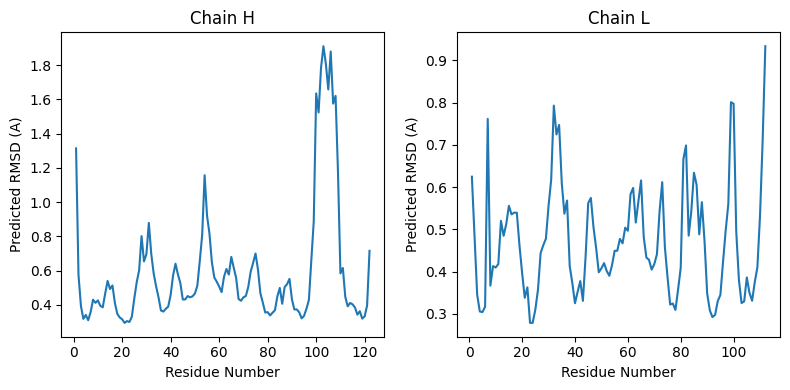

In [7]:
#@title Plot per-residue predicted RMSD

prmsd_fig_file = os.path.join(pred_dir, f"{name}_prmsd.png")
plot_prmsd(sequences, pred.prmsd.cpu(), prmsd_fig_file, shade_cdr=do_renum, pdb_file=pred_pdb)

In [8]:
#@title Show predicted structure with predicted RMSD

#@markdown Structure is colored from low (blue) to high (red) pRMSD.

show_pdb(pred_pdb, len(sequences), bb_sticks=False, sc_sticks=True, color="b")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
#@title Download results

#@markdown Download zip file containing structure prediction and annotation results. If download fails, results are also accessible from file explorer on the left panel of the notebook.

from google.colab import files
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!zip -FSr $name".result.zip" $pred_dir/ &> /dev/null
files.download(f"{name}.result.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>